In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from collections import Counter
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import pyasn
from iso3166 import countries

In [2]:
from numpy.random import uniform, normal, poisson, binomial
from scipy import stats
import seaborn as sns
import statsmodels.formula.api as smf 
import statsmodels.api as sm

# DATA PREPARATION

### Abuse report data

In [3]:
data = pd.read_csv("merge_result.csv")
data

,Unnamed: 0,id,dateadded,url,url_status,threat,tags,urlhaus_link,reporter,AS_Number
0,0,544165,9/17/2020 10:10,http://115.98.1.103:56034/Mozi.a,offline,malware_download,None,https://urlhaus.abuse.ch/url/544165/,lrz_security,17488
1,1,544163,9/17/2020 10:10,http://115.97.82.185:47119/Mozi.m,online,malware_download,"elf,Mozi",https://urlhaus.abuse.ch/url/544163/,lrz_security,17488
2,2,544164,9/17/2020 10:10,http://115.97.83.180:58110/Mozi.m,online,malware_download,"elf,Mozi",https://urlhaus.abuse.ch/url/544164/,lrz_security,17488
3,3,544162,9/17/2020 10:10,http://115.98.145.51:60363/Mozi.m,online,malware_download,"elf,Mozi",https://urlhaus.abuse.ch/url/544162/,lrz_security,17488
4,4,544161,9/17/2020 10:10,http://115.97.80.186:42284/Mozi.m,online,malware_download,"elf,Mozi",https://urlhaus.abuse.ch/url/544161/,lrz_security,17488
...,...,...,...,...,...,...,...,...,...,...
108757,108757,435287,8/18/2020 0:04,http://14.157.58.114:35300/Mozi.m,offline,malware_download,Mozi,https://urlhaus.abuse.ch/url/435287/,Gandylyan1,4134
108758,108758,435286,8/18/2020 0:04,http://180.106.132.202:53524/Mozi.m,offline,malware_download,Mozi,https://urlhaus.abuse.ch/url/435286/,Gandylyan1,4134
108759,108759,435285,8/18/2020 0:04,http://36.105.58.7:38745/Mozi.m,offline,malware_download,"elf,Mozi",https://urlhaus.abuse.ch/url/435285/,lrz_security,4134
108760,108760,435284,8/18/2020 0:03,http://johnsonlam.com/download/available_2mrDR...,online,malware_download,"doc,emotet,epoch1,heodo",https://urlhaus.abuse.ch/url/435284/,Cryptolaemus1,46015


### Reaction time per country data

In [4]:
react_time = pd.read_csv("reactspeedURLhaus_inminutes.csv")
react_time.head()

,rank,AS_Number,Name,Country,Online,Offline,months,days,hours,minutes,total_in_minutes
0,1,52715,SCORPION TELECOMUNICACAO RIBEIRAO PR ...,BR,0,1,0,0,0,3,3
1,2,13022,STREAMS_GMBH,AT,0,1,0,0,0,5,5
2,3,22438,CLEAR-RATE-COMMUNICATIONS,US,0,1,0,0,0,7,7
3,4,137344,IDNIC-TRANSTEKNO-AS-ID PT. TRANS NAS ...,ID,0,1,0,0,0,7,7
4,5,17716,NTU-TW National Taiwan University,TW,0,1,0,0,0,8,8


## Number of malware URLs per country

In [5]:
react_time['URL count'] = react_time['Online'] + react_time['Offline']
react_time.head()

,rank,AS_Number,Name,Country,Online,Offline,months,days,hours,minutes,total_in_minutes,URL count
0,1,52715,SCORPION TELECOMUNICACAO RIBEIRAO PR ...,BR,0,1,0,0,0,3,3,1
1,2,13022,STREAMS_GMBH,AT,0,1,0,0,0,5,5,1
2,3,22438,CLEAR-RATE-COMMUNICATIONS,US,0,1,0,0,0,7,7,1
3,4,137344,IDNIC-TRANSTEKNO-AS-ID PT. TRANS NAS ...,ID,0,1,0,0,0,7,7,1
4,5,17716,NTU-TW National Taiwan University,TW,0,1,0,0,0,8,8,1


In [6]:
url_count=react_time.groupby('Country').sum()['URL count'].to_frame()
url_count.columns=['URL count']
url_count=url_count.reset_index()
url_count.sort_values('URL count', ascending=False)

,Country,URL count
146,US,155472
64,IN,86436
30,CN,40651
38,DE,18656
124,RU,16896
...,...,...
59,HT,1
69,JM,1
155,YE,1
127,SD,1


## Average reaction time per country

In [7]:
time_mean=react_time.groupby('Country').mean()['total_in_minutes'].to_frame()
time_mean.columns = ['Reaction time mean']
time_mean=time_mean.reset_index()
time_mean.head()

,Country,Reaction time mean
0,AE,50664.250000
1,AL,54086.846154
2,AM,120297.666667
3,AR,44259.701754
4,AT,26164.400000


## IP space

In [8]:
asndb = pyasn.pyasn("ipasn_20150113.dat")

In [9]:
#get AS prefixes
tes=asndb.get_as_prefixes(52715)
tes

{'177.84.20.0/22',
 '177.84.20.0/24',
 '177.84.21.0/24',
 '177.84.22.0/24',
 '177.84.23.0/24'}

In [10]:
#get IP space per prefix 2^(32-/n)
for i in tes:
    print(2**(32-(int(i.split('/')[-1]))))

256
256
256
1024
256


In [11]:
all_ip_space=[]

for row in range(len(react_time)):
    
    ip_space = 0
    asn = (react_time.iloc[row,1])
    
    if asn != 'None':
        
        prefixes = asndb.get_as_prefixes(asn)

        if prefixes is not None:
            for ip in prefixes:
                ip_space += 2**(32-(int(ip.split('/')[-1])))
            all_ip_space.append(ip_space)
        else:
            all_ip_space.append(0)
    else:
        all_ip_space.append(0)
        
len(all_ip_space)

4813

In [12]:
react_time['IP space']=all_ip_space
react_time.head()

,rank,AS_Number,Name,Country,Online,Offline,months,days,hours,minutes,total_in_minutes,URL count,IP space
0,1,52715,SCORPION TELECOMUNICACAO RIBEIRAO PR ...,BR,0,1,0,0,0,3,3,1,2048
1,2,13022,STREAMS_GMBH,AT,0,1,0,0,0,5,5,1,6400
2,3,22438,CLEAR-RATE-COMMUNICATIONS,US,0,1,0,0,0,7,7,1,13312
3,4,137344,IDNIC-TRANSTEKNO-AS-ID PT. TRANS NAS ...,ID,0,1,0,0,0,7,7,1,0
4,5,17716,NTU-TW National Taiwan University,TW,0,1,0,0,0,8,8,1,76800


In [13]:
IP_space_ctr=react_time.groupby('Country').sum()['IP space'].to_frame().reset_index()
IP_space_ctr=IP_space_ctr.sort_values(by='IP space', ascending=False)
IP_space_ctr

,Country,IP space
146,US,494189994
30,CN,383767296
71,JP,172025584
38,DE,157256250
75,KR,116083784
...,...,...
34,CV,0
154,XK,0
155,YE,0
126,SC,0


In [14]:
IP_space_ctr=IP_space_ctr[IP_space_ctr['IP space']!=0]
IP_space_ctr

,Country,IP space
146,US,494189994
30,CN,383767296
71,JP,172025584
38,DE,157256250
75,KR,116083784
...,...,...
153,VU,14592
82,LR,10752
26,CG,6656
25,CD,4864


## Rule of Law Index

In [15]:
rol=pd.read_csv('Rule of Law Index.csv')
rol.head()

,Country Code,Rule of Law Index
0,AFG,0.36
1,ALB,0.50
2,DZA,0.49
3,AGO,0.43
4,ATG,0.63


In [16]:
Country=[]
for row in range(len(rol)):
    ctr=rol.iloc[row,0]
    ccode=countries.get(ctr).alpha2
    Country.append(ccode)
rol['Country']=Country
rol.head()

,Country Code,Rule of Law Index,Country
0,AFG,0.36,AF
1,ALB,0.50,AL
2,DZA,0.49,DZ
3,AGO,0.43,AO
4,ATG,0.63,AG


# MERGING OF DATA

In [17]:
factor=pd.merge(url_count,time_mean,on='Country',how='inner')
factor

,Country,URL count,Reaction time mean
0,AE,16,50664.250000
1,AL,38,54086.846154
2,AM,17,120297.666667
3,AR,531,44259.701754
4,AT,177,26164.400000
...,...,...,...
153,VU,4,36.000000
154,XK,3389,24367.000000
155,YE,1,587.000000
156,ZA,988,57874.634146


In [18]:
factor=pd.merge(factor,IP_space_ctr,on='Country',how='inner')
factor

,Country,URL count,Reaction time mean,IP space
0,AE,16,50664.250000,9214208
1,AL,38,54086.846154,313600
2,AM,17,120297.666667,614656
3,AR,531,44259.701754,20933056
4,AT,177,26164.400000,4106368
...,...,...,...,...
148,VI,1,571415.000000,43520
149,VN,5159,33377.267857,32344096
150,VU,4,36.000000,14592
151,ZA,988,57874.634146,30727112


In [19]:
factor=pd.merge(factor,rol[['Country','Rule of Law Index']],on='Country',how='inner')
factor

,Country,URL count,Reaction time mean,IP space,Rule of Law Index
0,AE,16,50664.250000,9214208,0.65
1,AL,38,54086.846154,313600,0.50
2,AR,531,44259.701754,20933056,0.58
3,AT,177,26164.400000,4106368,0.82
4,AU,1225,34194.742424,34648755,0.80
...,...,...,...,...,...
103,UZ,143,37006.777778,92928,0.47
104,VE,73,92883.125000,4650752,0.27
105,VN,5159,33377.267857,32344096,0.49
106,ZA,988,57874.634146,30727112,0.59


# FACTOR ANALYSIS

Checking the skewness of data. Use log transformation for highliy skewed data (following Tajalizadehkhoob)

(array([45., 35., 12.,  7.,  2.,  3.,  2.,  0.,  1.,  1.]),
 array([3.910000e+02, 4.067270e+04, 8.095440e+04, 1.212361e+05,
        1.615178e+05, 2.017995e+05, 2.420812e+05, 2.823629e+05,
        3.226446e+05, 3.629263e+05, 4.032080e+05]),
 <a list of 10 Patch objects>)

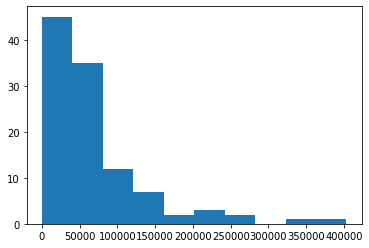

In [20]:
plt.hist(factor['Reaction time mean'])

(array([100.,   3.,   1.,   2.,   0.,   0.,   0.,   1.,   0.,   1.]),
 array([3.07200000e+03, 4.94217642e+07, 9.88404564e+07, 1.48259149e+08,
        1.97677841e+08, 2.47096533e+08, 2.96515225e+08, 3.45933917e+08,
        3.95352610e+08, 4.44771302e+08, 4.94189994e+08]),
 <a list of 10 Patch objects>)

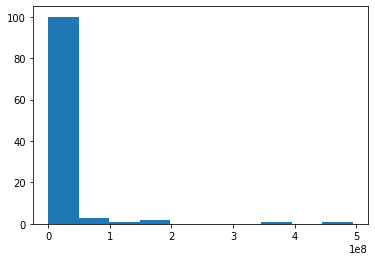

In [21]:
plt.hist(factor['IP space'])

(array([ 2.,  6., 16., 32., 14.,  9.,  8.,  6.,  9.,  6.]),
 array([0.27 , 0.333, 0.396, 0.459, 0.522, 0.585, 0.648, 0.711, 0.774,
        0.837, 0.9  ]),
 <a list of 10 Patch objects>)

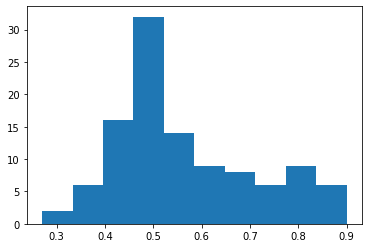

In [22]:
plt.hist(factor['Rule of Law Index'])

In [23]:
factor['log10(Reaction time mean)']=np.log10(factor['Reaction time mean'])
factor['log10(IP space)']=np.log10(factor['IP space'])
factor

,Country,URL count,Reaction time mean,IP space,Rule of Law Index,log10(Reaction time mean),log10(IP space)
0,AE,16,50664.250000,9214208,0.65,4.704702,6.964458
1,AL,38,54086.846154,313600,0.50,4.733092,5.496376
2,AR,531,44259.701754,20933056,0.58,4.646008,7.320833
3,AT,177,26164.400000,4106368,0.82,4.417711,6.613458
4,AU,1225,34194.742424,34648755,0.80,4.533959,7.539688
...,...,...,...,...,...,...,...
103,UZ,143,37006.777778,92928,0.47,4.568281,4.968147
104,VE,73,92883.125000,4650752,0.27,4.967937,6.667523
105,VN,5159,33377.267857,32344096,0.49,4.523451,7.509795
106,ZA,988,57874.634146,30727112,0.59,4.762488,7.487522


In [24]:
y=factor[['URL count']]
y

,URL count
0,16
1,38
2,531
3,177
4,1225
...,...
103,143
104,73
105,5159
106,988


## First Model: "Rule of Law Index"

In [34]:
x=factor[['Rule of Law Index']]

exog, endog = sm.add_constant(x), y

# Poisson regression
mod = sm.GLM(endog, exog, family=sm.families.Poisson(link=sm.families.links.log()))
res = mod.fit()
display(res.summary())

y_pred = res.predict(exog)

llfull=res.llf
llnull=res.llnull
pseudor2=1-(llfull/llnull)
print('Explained Variance (Pseudo-R2) = ',pseudor2)

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              URL count   No. Observations:                  108
Model:                            GLM   Df Residuals:                      106
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -9.2933e+05
Date:                Mon, 05 Oct 2020   Deviance:                   1.8579e+06
Time:                        18:53:00   Pearson chi2:                 7.04e+06
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 6.3515      0.006    986.837      0.000       6.339       6.364
Rule of Law Index     3.2399      0.010    330.576      0.000       3.221       3.259
=====================================================================================
"""

Explained Variance (Pseudo-R2) =  0.053769111055058105


Text(0, 0.5, 'Y')

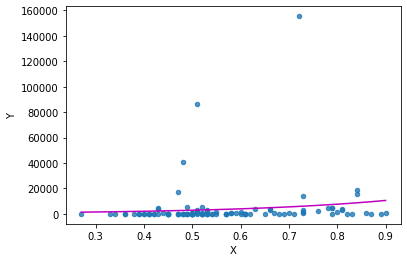

In [27]:
y_pred=y_pred.to_frame()

idx=pd.Index(x['Rule of Law Index'])
order=idx.argsort()
x_ord=x.reindex(order)
y_pred_ord=y_pred.reindex(order)

plt.plot(x_ord, y_pred_ord, color='m')
plt.scatter(x['Rule of Law Index'], y,  s=20, alpha=0.8)
plt.xlabel("X")
plt.ylabel("Y")

## Second Model: "Reaction time mean"

In [35]:
x=factor[['log10(Reaction time mean)']]

exog, endog = sm.add_constant(x), y

# Poisson regression
mod = sm.GLM(endog, exog, family=sm.families.Poisson(link=sm.families.links.log()))
res = mod.fit()
display(res.summary())

y_pred = res.predict(exog)

llfull=res.llf
llnull=res.llnull
pseudor2=1-(llfull/llnull)
print('Explained Variance (Pseudo-R2) = ',pseudor2)

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              URL count   No. Observations:                  108
Model:                            GLM   Df Residuals:                      106
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -9.7930e+05
Date:                Mon, 05 Oct 2020   Deviance:                   1.9579e+06
Time:                        18:53:08   Pearson chi2:                 8.13e+06
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         7.3264      0.013    544.160      0.000       7.300       7.353
log10(Reaction time mean)     0.2095      0.003     73.056      0.000       0.204       0.215
=============================================================================================
"""

Explained Variance (Pseudo-R2) =  0.0028936748016888947


Text(0, 0.5, 'Y')

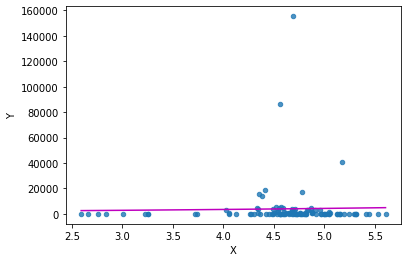

In [36]:
y_pred=y_pred.to_frame()

idx=pd.Index(x['log10(Reaction time mean)'])
order=idx.argsort()
x_ord=x.reindex(order)
y_pred_ord=y_pred.reindex(order)

plt.plot(x_ord, y_pred_ord, color='m')
plt.scatter(x['log10(Reaction time mean)'], y,  s=20, alpha=0.8)
plt.xlabel("X")
plt.ylabel("Y")

## Third Model: "IP Space"

In [37]:
x=factor[['log10(IP space)']]

exog, endog = sm.add_constant(x), y

# Poisson regression
mod = sm.GLM(endog, exog, family=sm.families.Poisson(link=sm.families.links.log()))
res = mod.fit()
display(res.summary())

y_pred = res.predict(exog)

llfull=res.llf
llnull=res.llnull
pseudor2=1-(llfull/llnull)
print('Explained Variance (Pseudo-R2) = ',pseudor2)

C:\Users\stell\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              URL count   No. Observations:                  108
Model:                            GLM   Df Residuals:                      106
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -3.1230e+05
Date:                Mon, 05 Oct 2020   Deviance:                   6.2387e+05
Time:                        18:53:11   Pearson chi2:                 1.47e+06
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -7.7232      0.019   -414.205      0.000      -7.760      -7.687
log10(IP space)     2.1973      0.002    945.231      0.000       2.193       2.202
===================================================================================
"""

Explained Variance (Pseudo-R2) =  0.6820184573919142


Text(0, 0.5, 'Y')

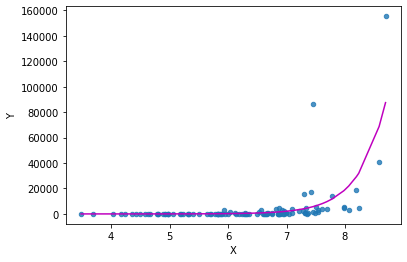

In [38]:
y_pred=y_pred.to_frame()

idx=pd.Index(x['log10(IP space)'])
order=idx.argsort()
x_ord=x.reindex(order)
y_pred_ord=y_pred.reindex(order)

plt.plot(x_ord, y_pred_ord, color='m')
plt.scatter(x['log10(IP space)'], y,  s=20, alpha=0.8)
plt.xlabel("X")
plt.ylabel("Y")

## Fourth Model: 3 Factor - "Reaction time mean", "IP Space", "Rule of Law Index"

In [39]:
x=factor[['log10(Reaction time mean)','log10(IP space)','Rule of Law Index']]

exog, endog = sm.add_constant(x), y

# Poisson regression
mod = sm.GLM(endog, exog, family=sm.families.Poisson(link=sm.families.links.log()))
res = mod.fit()
display(res.summary())

y_pred = res.predict(exog)

llfull=res.llf
llnull=res.llnull
pseudor2=1-(llfull/llnull)
print('Explained Variance (Pseudo-R2) = ',pseudor2)

C:\Users\stell\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              URL count   No. Observations:                  108
Model:                            GLM   Df Residuals:                      104
Model Family:                 Poisson   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.9880e+05
Date:                Mon, 05 Oct 2020   Deviance:                   5.9686e+05
Time:                        18:53:13   Pearson chi2:                 1.28e+06
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -5.1031      0.022   -229.424      0.000      -5.147      -5.060
log10(Reaction time mean)    -0.6993      0.005   -154.312      0.000      -0.708      -0.690
log10(IP space)               2.4079      0.003    862.121      0.000       2.402       2.413
Rule of Law Index            -1.5837      0.012   -134.017      0.000      -1.607      -1.560
=============================================================================================
"""

Explained Variance (Pseudo-R2) =  0.695767701892986
